759


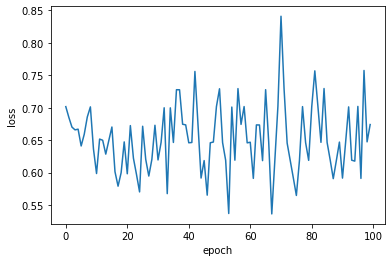

In [14]:
# lecture8: 记载数据集，分batch训练
## 这玩意不收敛啊
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
 
# prepare dataset
 
 
class DiabetesDataset(Dataset):
    def __init__(self, filepath):
        xy = np.loadtxt(filepath, delimiter=',', dtype=np.float32)
        self.len = xy.shape[0] # shape(多少行，多少列)
        self.x_data = torch.from_numpy(xy[:, :-1])
        self.y_data = torch.from_numpy(xy[:, [-1]])
 
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
 
    def __len__(self):
        return self.len
 
 
dataset = DiabetesDataset('diabetes.csv')
print(len(dataset))
train_loader = DataLoader(dataset=dataset, batch_size=32, shuffle=True, num_workers=0) #num_workers 多线程,我这里可能是因为这个代码的版本太低，用不了，后面查查1.8.0的dataloader怎么用
 
 
# design model using class
 
 
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = torch.nn.Linear(8, 6)
        self.linear2 = torch.nn.Linear(6, 4)
        self.linear3 = torch.nn.Linear(4, 1)
        self.sigmoid = torch.nn.Sigmoid()
 
    def forward(self, x):
        x = self.sigmoid(self.linear1(x))
        x = self.sigmoid(self.linear2(x))
        x = self.sigmoid(self.linear3(x))
        return x
 
 
model = Model()
 
# construct loss and optimizer
criterion = torch.nn.BCELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
epoch_list = []
loss_list = []
# training cycle forward, backward, update
# 分batch训练，本质上一个batch采用的就是向量化的读入，然后len是759，所以我们这里每一个epoch有24轮，这里轮与轮之间采用的是随机梯度下降法
if __name__ == '__main__':
    for epoch in range(100):
        for i, data in enumerate(train_loader, 0): # train_loader 是先shuffle后mini_batch
            inputs, labels = data
            y_pred = model(inputs)
            loss = criterion(y_pred, labels)
            #print("epoch", epoch, "这个epoch里的第几轮", i, loss.item())
 
            optimizer.zero_grad()
            loss.backward()
 
            optimizer.step()
        epoch_list.append(epoch)
        loss_list.append(loss.item())
plt.plot(epoch_list, loss_list)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [9]:
759/32


23.71875

In [1]:
# lecture9 多分类问题，mnist demo
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
 
# prepare dataset
 
batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]) # 归一化,均值和方差，对于mnist数据集的均值和方差就这么取
 
train_dataset = datasets.MNIST(root='../dataset/mnist/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataset = datasets.MNIST(root='../dataset/mnist/', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

# 注意训练集和测试集的预处理是一样的，正常应当是在训练集上算出方差以及均值，然后到test里面应用 
# design model using class
 
 
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = torch.nn.Linear(784, 512)
        self.l2 = torch.nn.Linear(512, 256)
        self.l3 = torch.nn.Linear(256, 128)
        self.l4 = torch.nn.Linear(128, 64)
        self.l5 = torch.nn.Linear(64, 10)
 
    def forward(self, x):
        x = x.view(-1, 784)  # -1其实就是自动获取mini_batch
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        return self.l5(x)  # 最后一层不做激活，不进行非线性变换,因为我们用的交叉墒损失函数
 
 
model = Net()
 
# construct loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
 
# training cycle forward, backward, update
 
 
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        # 获得一个批次的数据和标签
        inputs, target = data
        optimizer.zero_grad()
        # 获得模型预测结果(64, 10)
        outputs = model(inputs)
        # 交叉熵代价函数outputs(64,10),target（64）
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
 
 
        running_loss += loss.item()
        if batch_idx % 300 == 299:
            print('[%d, %5d] loss: %.3f' % (epoch+1, batch_idx+1, running_loss/300))
            running_loss = 0.0
 
 
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1) # dim = 1 列是第0个维度，行是第1个维度
            total += labels.size(0)
            correct += (predicted == labels).sum().item() # 张量之间的比较运算
    print('accuracy on test set: %d %% ' % (100*correct/total))     #由于是百分比所以乘100
 
 
if __name__ == '__main__':
    for epoch in range(10):
        train(epoch)
        test()

[1,   300] loss: 2.221
[1,   600] loss: 0.950
[1,   900] loss: 0.433
accuracy on test set: 90 % 
[2,   300] loss: 0.322
[2,   600] loss: 0.283
[2,   900] loss: 0.236
accuracy on test set: 93 % 
[3,   300] loss: 0.199
[3,   600] loss: 0.171
[3,   900] loss: 0.159
accuracy on test set: 95 % 
[4,   300] loss: 0.136
[4,   600] loss: 0.128
[4,   900] loss: 0.121
accuracy on test set: 96 % 
[5,   300] loss: 0.102
[5,   600] loss: 0.099
[5,   900] loss: 0.096
accuracy on test set: 96 % 
[6,   300] loss: 0.082
[6,   600] loss: 0.080
[6,   900] loss: 0.075
accuracy on test set: 97 % 
[7,   300] loss: 0.066
[7,   600] loss: 0.060
[7,   900] loss: 0.064
accuracy on test set: 96 % 
[8,   300] loss: 0.050
[8,   600] loss: 0.055
[8,   900] loss: 0.050
accuracy on test set: 97 % 
[9,   300] loss: 0.041
[9,   600] loss: 0.042
[9,   900] loss: 0.043
accuracy on test set: 97 % 
[10,   300] loss: 0.032
[10,   600] loss: 0.033
[10,   900] loss: 0.036
accuracy on test set: 97 % 


In [18]:
employee_names = ["Paul", "John", "Abbie", "Charlotte", "Ron"]

for index, name in enumerate(employee_names):
	print(index, name)

0 Paul
1 John
2 Abbie
3 Charlotte
4 Ron


In [19]:
employee_names = ["Paul", "John", "Abbie", "Charlotte", "Ron"]


for index, name in enumerate(employee_names, 1):
	print(index, name)

1 Paul
2 John
3 Abbie
4 Charlotte
5 Ron
